# Transfer learning

如果一个模型是在大型和通用数据集上训练出来的，那么这个模型就可以作为相关任务的模版。

迁移学习：将预训练模型作为起点，通过添加新的层或者对原有层进行微调，来解决新的问题。

如何使用预训练模型：

1. 特征提取：不需要重新训练模型，而是利用基础模型已经学习到的特征处理新的任务，只需要修改最顶层的网络，将其替换为自己的分类器。
2. 微调(Fine-tuing)：解冻基础模型的几个顶层，并联合训练新添加的分类器层和基础模型的最后几层。这样可以“微调”基础模型已经学习到的特征，使其与新任务更加相关。

工作流程：

1. 了解数据
2. 创建输入数据的数据集
3. 创建组合模型
4. 训练模型
5. 评估模型

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

plt.style.use("ggplot")

# 输入数据

使用`image_dataset_from_directory`来创建数据集，包括训练集，验证集和测试集。

文件夹和图像文件需要遵循以下范式：

dataset_root_dir/
  - class_a/
    - 00001.png
    - 00002.png
  - class_b/
    - 00001.png
    - 00002.png
  - class_c/
    - 00001.png
    - 00002.png

In [2]:
image_height = 224
image_width = 224

train_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/train",
    batch_size=32,
    image_size=(image_height, image_width),
    validation_split=0,
    seed=123
)

val_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/validation/",
    batch_size=32,
    image_size=(image_height, image_width),
)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/test",
    batch_size=32,
    image_size=(image_height, image_width)
)

Found 3114 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


2023-10-30 21:04:31.913160: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-30 21:04:31.913188: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-30 21:04:31.913198: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-30 21:04:31.913238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-30 21:04:31.913255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
class_names = train_set.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


查看训练集的图像。

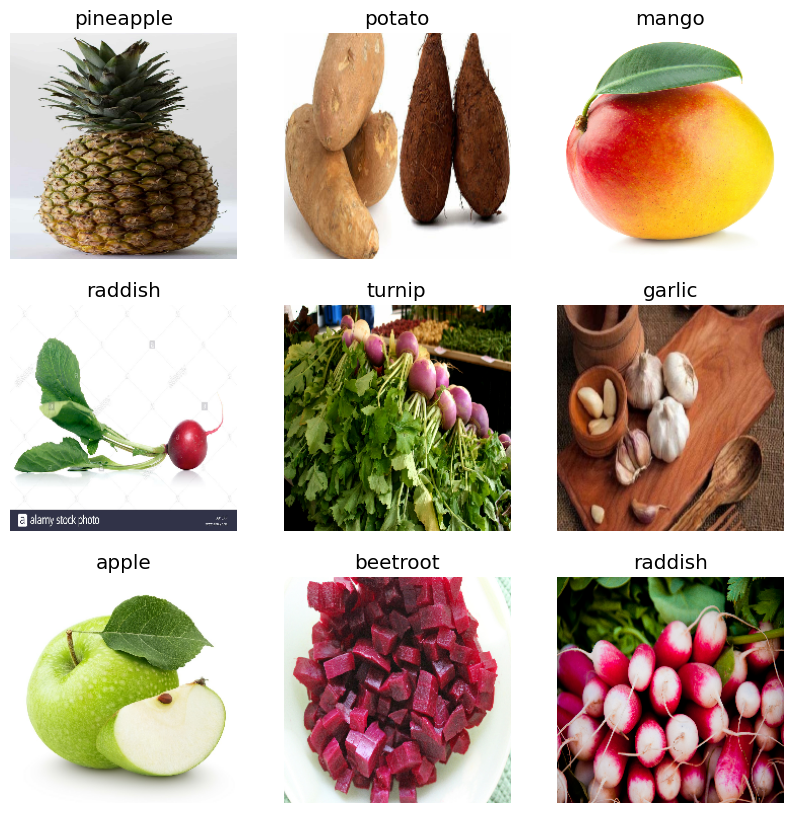

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))
for images, labels in train_set.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[labels[i]])
        ax.axis("off")

# MobileNet V2

加载预训练模型

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_height, image_width, 3),  # shape of input image
    include_top=False,  # final classificattion layer of pretrained model is not included
    weights="imagenet"  # model should be initialized with weights from imagenet
)

冻结基础模型，不需要重新训练，保留预训练模型的所有权重。

In [6]:
base_model.trainable = False  # freeze the weights of the pretrained model

添加分类头

In [7]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1, input_shape=(image_height, image_width, 3)),  # mobilenet v2 expects pixel values in [-1, 1]
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes)
])

编译模型

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 36)                46116     
                                                                 
Total params: 2304100 (8.79 MB)
Trainable params: 46116 (180.14 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


训练模型

In [10]:
epochs = 10
history = model.fit(
    train_set, validation_data=val_set, epochs=epochs
)

Epoch 1/10


2023-10-30 21:05:08.397876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 58s 483ms/step - loss: 1.6831 - accuracy: 0.5739 - val_loss: 0.5961 - val_accuracy: 0.8547
Epoch 2/10
98/98 [==============================] - 32s 301ms/step - loss: 0.5923 - accuracy: 0.8443 - val_loss: 0.3784 - val_accuracy: 0.9060
Epoch 3/10
98/98 [==============================] - 31s 297ms/step - loss: 0.4088 - accuracy: 0.8953 - val_loss: 0.2927 - val_accuracy: 0.9288
Epoch 4/10
98/98 [==============================] - 31s 297ms/step - loss: 0.3083 - accuracy: 0.9232 - val_loss: 0.2497 - val_accuracy: 0.9402
Epoch 5/10
98/98 [==============================] - 31s 298ms/step - loss: 0.2411 - accuracy: 0.9432 - val_loss: 0.2174 - val_accuracy: 0.9544
Epoch 6/10
98/98 [==============================] - 31s 297ms/step - loss: 0.1947 - accuracy: 0.9602 - val_loss: 0.2019 - val_accuracy: 0.9601
Epoch 7/10
98/98 [==============================] - 31s 296ms/step - loss: 0.1648 - accuracy: 0.9660 - val_loss: 0.1860 - val_accuracy: 0.9573
Epoch 8/10

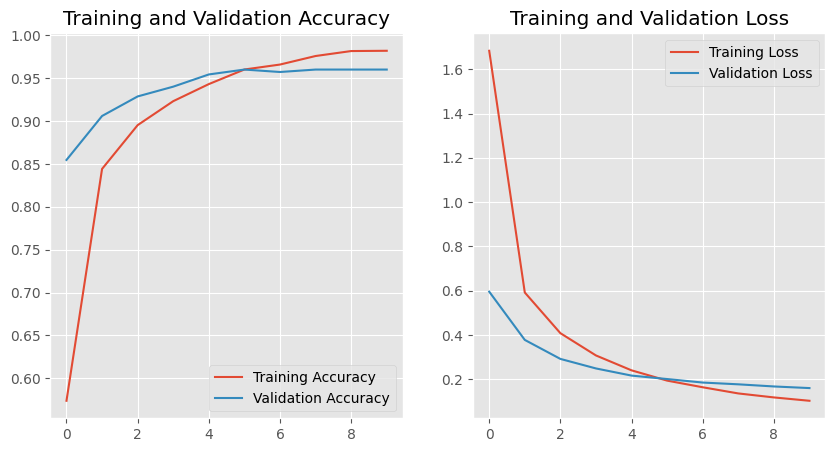

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

评估模型

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2%}")

12/12 [==============================] - 10s 690ms/step - loss: 0.1611 - accuracy: 0.9610
Loss: 0.16
Accuracy: 96.10%


# 微调模型

如何理解微调模型？

* 微调模型是指解冻基础模型的最后几层，然后联合训练解冻的层和新添加的分类层，这样可以令模型学习到更加专业的特征，使其与新任务更加相关。
* 只需要微调少量顶层即可，不要调整太多层。在大多数卷积神经网络中，前几层学习到的是一些简单和通用的特征，几乎适用于所有图像，越往后特征会更加针对训练数据。
* 微调模型是提高性能的一种办法。
* 只有在基础模型设置为不可训练的情况下训练完顶层分类器后才可以微调模型，否则预训练模型将忘记所有学习过的内容。

如何实现微调模型？

解冻预训练模型的最后几层，但底层仍设置为不可训练，然后重新编译模型并继续训练。

In [13]:
# first unfreeze the base model
base_model.trainable = True

# Take a look at how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model using a much-lower training rate.
model.compile(
    optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-5),  # lower learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 36)                46116     
                                                                 


Total params: 2304100 (8.79 MB)
Trainable params: 1907556 (7.28 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [14]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_set,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_set
)

Epoch 10/20
98/98 [==============================] - 92s 528ms/step - loss: 0.5935 - accuracy: 0.8186 - val_loss: 0.1622 - val_accuracy: 0.9573
Epoch 11/20
98/98 [==============================] - 32s 308ms/step - loss: 0.3748 - accuracy: 0.8966 - val_loss: 0.1646 - val_accuracy: 0.9573
Epoch 12/20
98/98 [==============================] - 32s 306ms/step - loss: 0.2749 - accuracy: 0.9261 - val_loss: 0.1634 - val_accuracy: 0.9601
Epoch 13/20
98/98 [==============================] - 32s 304ms/step - loss: 0.2285 - accuracy: 0.9419 - val_loss: 0.1608 - val_accuracy: 0.9573
Epoch 14/20
98/98 [==============================] - 32s 304ms/step - loss: 0.1854 - accuracy: 0.9592 - val_loss: 0.1554 - val_accuracy: 0.9601
Epoch 15/20
98/98 [==============================] - 32s 306ms/step - loss: 0.1580 - accuracy: 0.9637 - val_loss: 0.1495 - val_accuracy: 0.9573
Epoch 16/20
98/98 [==============================] - 32s 306ms/step - loss: 0.1364 - accuracy: 0.9724 - val_loss: 0.1451 - val_accuracy:

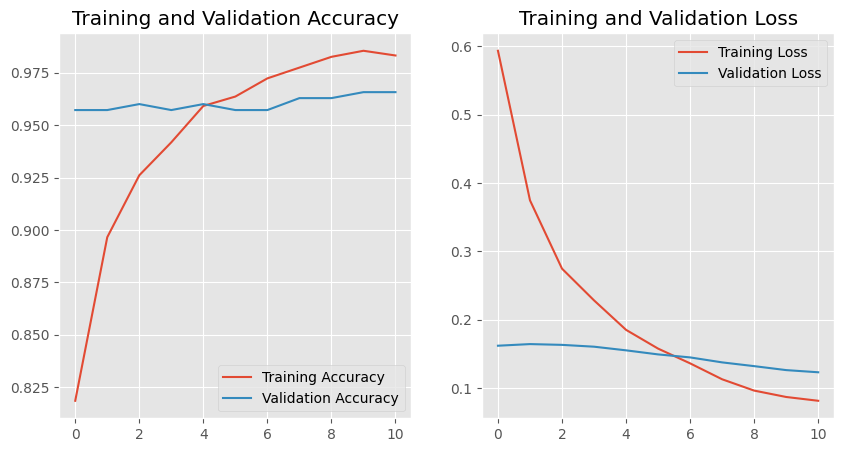

In [17]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs_range = range(fine_tune_epochs+1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2%}")

12/12 [==============================] - 10s 649ms/step - loss: 0.1212 - accuracy: 0.9666
Loss: 0.12
Accuracy: 96.66%
